In [22]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *
# set_plotting_style('latex')

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_simple = (band_centers/500)**(-1.2)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_scatter_simple_smooth = smooth_spectral(M_scatter_simple.T,5).T


c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


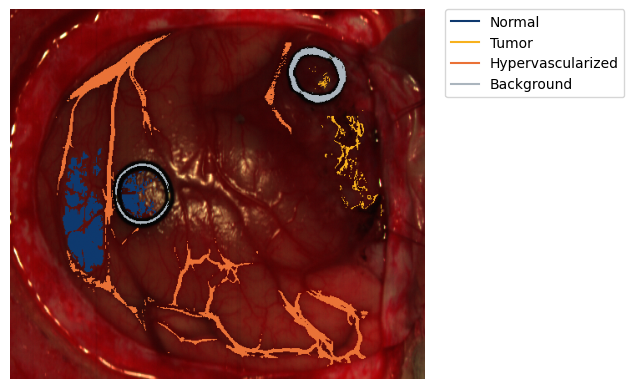

In [3]:
data_folder = "../../datasets/helicoid/012-01"
# data_folder = "../../datasets/helicoid/008-01"

class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")
plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

# preprocessing
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

### CEM

In [24]:
def cem(spectr, endmember):
    a,b,k = spectr.shape
    y = np.zeros((a,b))
    for i in tqdm(range(a)):
        for j in range(b):
            R = np.outer(spectr[i,j], spectr[i,j])/k
            R_inv = np.linalg.inv(R + 1e-8*np.eye(k))
            R_inv_d = R_inv @ endmember
            w = R_inv_d / np.sum(R_inv_d * endmember)
            y[i,j] = w @ spectr[i,j]
    return y

from pysptools.detection.detect import CEM

def cem_2d(spectr, endmember):
    shape = spectr.shape
    spectr = spectr.reshape(-1, shape[-1])
    y = CEM(spectr, endmember)
    return y.reshape(shape[:-1])

def clip_data(data, lower=5, upper=95):
    lower_clip = np.percentile(data, lower, axis=(0,1), keepdims=True)
    upper_clip = np.percentile(data, upper, axis=(0,1), keepdims=True)
    data = np.clip(data, lower_clip, upper_clip)
    return data

In [25]:
n = M_scatter_simple_smooth.shape[1]
data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
for i in range(n):
    data[:,:,i] = cem(absorbance, M_scatter_simple_smooth[:,i])
    break

# plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(2.8,2.5), legend_loc=None)
# plot_pca(data, gt_map, class_labels, mode='equal', figsize=(2.55,2.5), legend_loc=None)
# plot_concentrations(data, endmember_labels_scatter);

plot_concentrations(clip_data(data), endmember_labels_scatter);

  5%|▍         | 21/443 [02:33<51:25,  7.31s/it]  


KeyboardInterrupt: 